In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from matplotlib import pyplot as plt
from PIL import Image
from math import ceil

## Part 1

### 1 - 1

In [2]:
xs = np.array([0, 0.6, 1.03, 1.39, 1.76, 2.09, 2.29])
fs = np.exp(np.cos(3*xs))

In [3]:
def lagrange(deg):
    indxs = np.linspace(0, xs.shape[0]-1, deg+1)
    indxs = np.floor(indxs).astype(np.int32)
    x = xs[indxs]
    f = fs[indxs]

    ans = 0
    for i in range(deg+1):
        tmp = 1
        for j in range(deg+1):
            if j == i:
                continue
            tmp *= poly.Polynomial([x[j], -1]) / (x[j]-x[i])
        ans += f[i]*tmp
    return ans

In [4]:
xp = np.arange(0, 2.4, 0.05)
fp = []

for i in range(3, 7):
    p = lagrange(i)
    fp.append(p(xp))

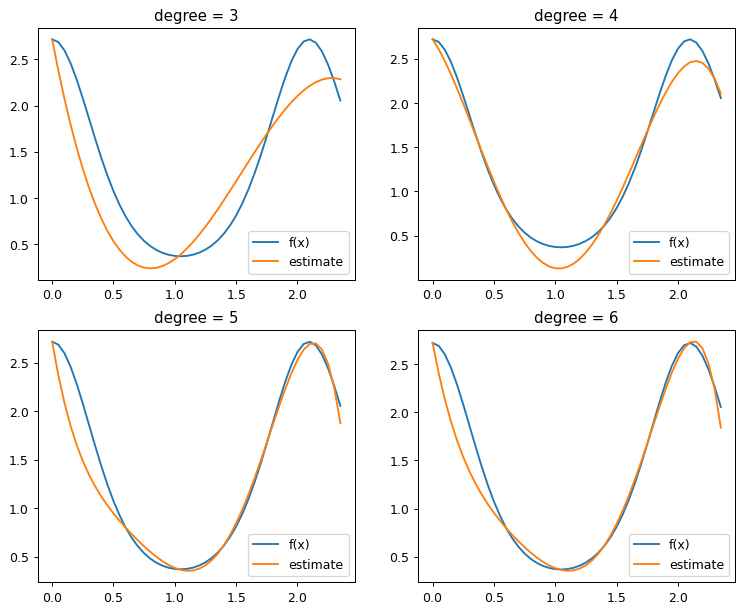

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=90)
fxp = np.exp(np.cos(3*xp))

for i in range(4):
    ax = axs[i//2, i%2]
    ax.plot(xp, fxp)
    ax.plot(xp, fp[i])
    ax.set_title(f"degree = {i+3}")
    ax.legend(["f(x)", "estimate"])

plt.show()

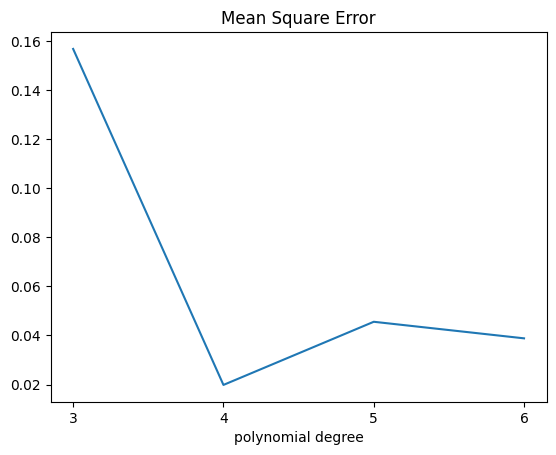

In [6]:
e = np.square(fxp - fp).mean(axis=1)
plt.plot(range(3, 7), e)
plt.xticks(range(3, 7))
plt.title('Mean Square Error')
plt.xlabel('polynomial degree')
plt.show()

### 1 - 2

In [7]:
def LU_factorize(M):
    n = M.shape[0]
    L = np.diag(np.ones(n))
    U = np.zeros(M.shape)

    U[0] = M[0]
    for i in range(n-1):
        L[i+1, i] = M[i+1, i] / U[i, i]
        U[i+1][i+1:] = M[i+1][i+1:] - L[i+1, i]*U[i][i+1:]
    
    return L, U

In [8]:
M = np.array([[4, 5, 6], [8, 7, 13], [0, 12, 4]])
L, U = LU_factorize(M)
L

array([[ 1.,  0.,  0.],
       [ 2.,  1.,  0.],
       [ 0., -4.,  1.]])

In [9]:
U

array([[ 4.,  5.,  6.],
       [ 0., -3.,  1.],
       [ 0.,  0.,  8.]])

## Part 2

### Compression

In [10]:
img = Image.open('2/256x256_color/1.tiff')
img = np.asarray(img.convert('L'))

In [11]:
def svd_compress(img, r):
    n = ceil(r/100 * img.shape[0])
    u, s, v = np.linalg.svd(img)
    return np.dot(np.dot(u[:, :n], np.diag(s)[:n, :n]), v[:n])

In [12]:
def fft_compress(img, r):
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    intensity = np.abs(img_fft)
    th = np.percentile(intensity, 100-r)
    filtered = img_fft * (th < intensity)
    return np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))

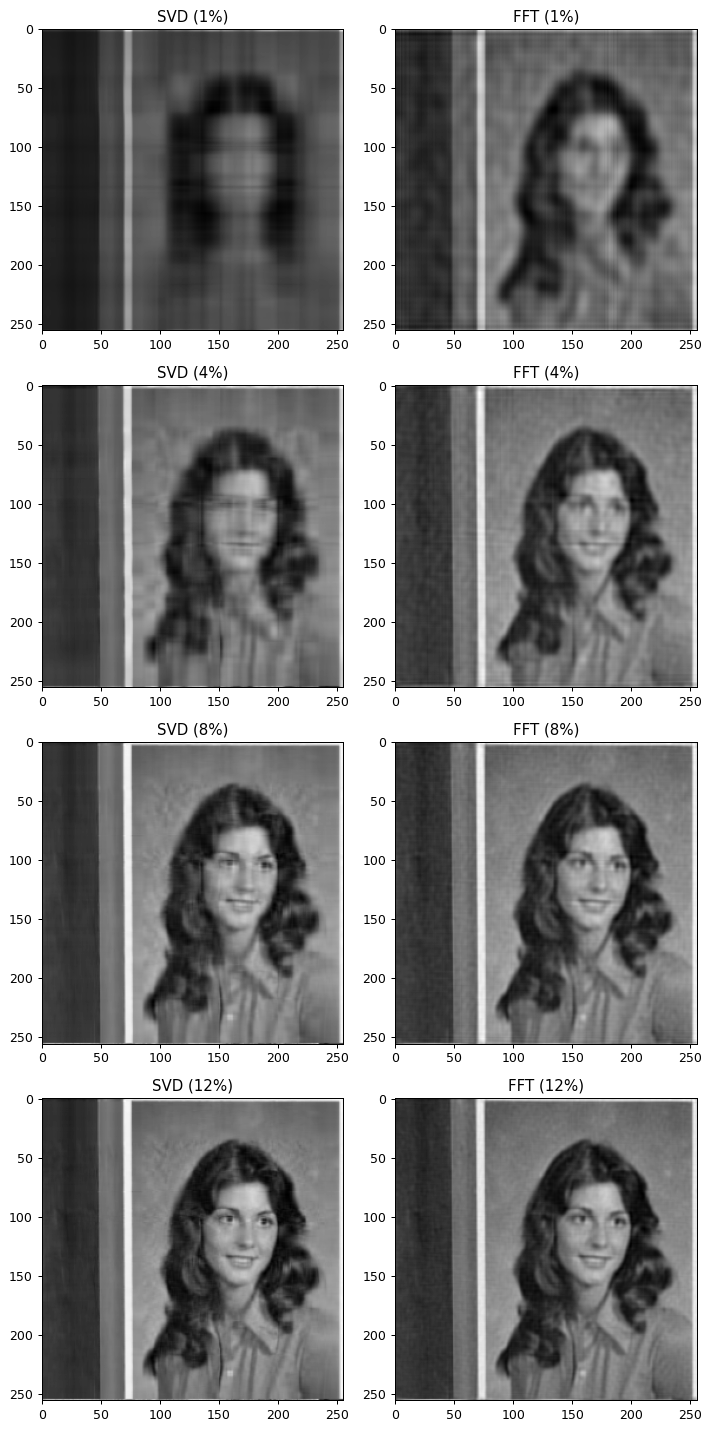

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(8, 16), dpi=90)
ratios = [1, 4, 8, 12]

for i in range(4):
    axs[i, 0].imshow(svd_compress(img, ratios[i]), cmap='gray')
    axs[i, 0].set_title(f"SVD ({ratios[i]}%)")
    axs[i, 1].imshow(fft_compress(img, ratios[i]), cmap='gray')
    axs[i, 1].set_title(f"FFT ({ratios[i]}%)")

fig.tight_layout()
plt.show()

### Denoising

In [14]:
img = Image.open('2/256x256_noisy/1.jpeg')
img = np.asarray(img.convert('L'))

In [15]:
def fft_lowpass(img, r):
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    x = np.linspace(-1, 1, img.shape[0])
    X, Y = np.meshgrid(x, x)
    lp_filter = np.exp(-(X**2 + Y**2) / r**2 * 2500)
    filtered = img_fft * lp_filter
    return np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))

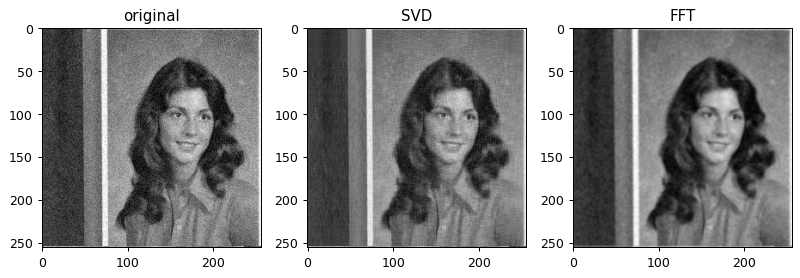

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=90)

axs[0].imshow(img, cmap='gray')
axs[0].set_title(f"original")

axs[1].imshow(svd_compress(img, 15), cmap='gray')
axs[1].set_title(f"SVD")

axs[2].imshow(fft_lowpass(img, 25), cmap='gray')
axs[2].set_title(f"FFT")

fig.tight_layout()
plt.show()

## Part 3

In [17]:
source_img = np.asarray(Image.open('3/Source.jpg'))
reference_img = np.asarray(Image.open('3/Reference.jpg'))

In [18]:
def find_nearest(source, indx, dest):
    distance = np.abs(dest - source[indx])
    min_indxs = np.where(distance == distance.min())[0]
    return min_indxs[np.abs(min_indxs - indx).argmin()]


def match_histogram(source_img, reference_img):
    source_hist, bins = np.histogram(source_img, 256, (0, 256))
    source_cdf = np.cumsum(source_hist / np.prod(source_img.shape))
    reference_hist, bins = np.histogram(reference_img, 256, (0, 256))
    reference_cdf = np.cumsum(reference_hist / np.prod(reference_img.shape))
    mapping = [find_nearest(source_cdf, i, reference_cdf) for i in range(256)]
    mapping = np.array(mapping, dtype=np.uint8)
    return mapping[source_img]

In [19]:
res = np.empty(source_img.shape, dtype=np.uint8)
for i in range(3):
    res[:, :, i] = match_histogram(source_img[:, :, i], reference_img[:, :, i])

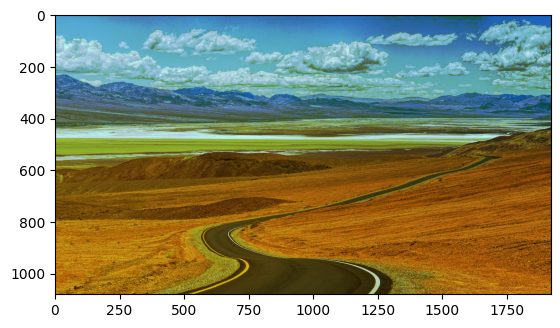

In [20]:
plt.imshow(res)
plt.show()

## Part 4

In [21]:
def gram_schmidt(A):
    Q = A / np.linalg.norm(A, axis=0)
    for i in range(1, A.shape[1]):
        Q[:, i] -= np.dot(Q[:, :i], np.dot(Q[:, i].T, Q[:, :i]).T)
        Q[:, i] /= np.linalg.norm(Q[:, i])

    return Q

In [22]:
A = np.array([[0, 0, 1], [1, 1, 1], [1, 2, 1]])
np.around(gram_schmidt(A), 3)

array([[ 0.   ,  0.   ,  1.   ],
       [ 0.707, -0.707,  0.   ],
       [ 0.707,  0.707, -0.   ]])

In [23]:
def improved_gram_schmidt(A):
    Q = A.copy().astype(dtype=np.float64)
    for i in range(A.shape[1]-1):
        Q[:, i] /= np.linalg.norm(Q[:, i])
        Q[:, i+1:] -= np.dot(Q[:, [i]], np.dot(Q[:, [i]].T, Q[:, i+1:]))

    Q[:, -1] /= np.linalg.norm(Q[:, -1])
    return Q

In [24]:
np.around(improved_gram_schmidt(A), 3)

array([[ 0.   ,  0.   ,  1.   ],
       [ 0.707, -0.707,  0.   ],
       [ 0.707,  0.707,  0.   ]])

In [25]:
def gen_test_matrix(n):
    U, X = np.linalg.qr(np.random.randn(n,n))
    V, X = np.linalg.qr(np.random.randn(n,n))
    S = np.diag(np.power(2,np.arange (-1,-(n+1) ,-1), dtype=np.float64))
    A = np.matmul(U,np.matmul(S,V))
    return A

def calc_error(Q, n):
    return np.linalg.norm(np.dot(Q.T, Q) - np.diag(np.ones(n)))

In [26]:
e1 = []
e2 = []

ns = np.arange(10, 100, 2)
for n in ns:
    A = gen_test_matrix(n)
    Q1 = gram_schmidt(A)
    e1.append(calc_error(Q1, n))
    Q2 = improved_gram_schmidt(A)
    e2.append(calc_error(Q2, n))

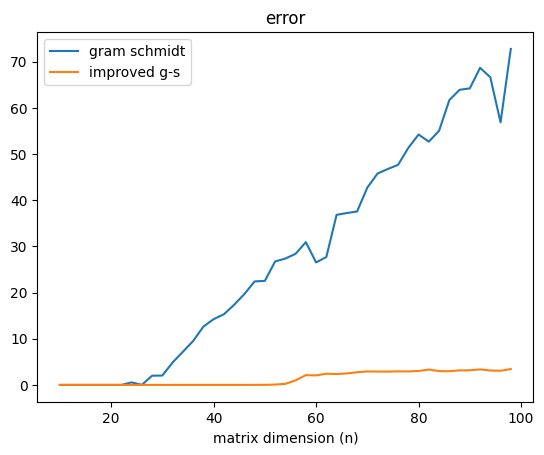

In [27]:
plt.plot(ns, e1, label="gram schmidt")
plt.plot(ns, e2, label="improved g-s")
plt.title("error")
plt.xlabel("matrix dimension (n)")
plt.legend()
plt.show()